In this notebook i try to make agents creating links based on their success in trades.  
To model agent's limitated knowledge of the environment he will take a random sample of agents and will create a bond with the most succesful trader.

In [1]:
%run _config.ipynb

In [12]:
def change_Prices(model):
    agent_wealth = [agent.wealth for agent in model.schedule.agents]
    agent_positions = [agent.position for agent in model.schedule.agents]
    agent_orders = [agent.order for agent in model.schedule.agents]
    
    sbo = 0 # sum buy orders
    sso = 0 # sum sell orders
    alfa = model.Price * 0.01 # coefficient for price updating
    
    for i in range(len(agent_positions)):
        if agent_positions[i] == 'long':
            sbo += agent_orders[i]
        elif agent_positions[i] == 'short':
            sso += agent_orders[i]
    
    delta = alfa * (sbo - sso)
    
    model.Last_Price = model.Price
    model.Price = model.Price + delta
    
    return model.Price

In [13]:
def get_graphlabels(ordered_dict):
    inv_dict = dict(zip(ordered_dict.values(), ordered_dict.keys()))
    return inv_dict

In [14]:
def plot_graph(schedule):
    G = schedule.net
    pos = nx.spring_layout(G)
    labels = get_graphlabels(schedule._agents)

    plt.figure(figsize=(8, 5))
    s = nx.draw_networkx_nodes(
        G,
        pos,
        node_size = 200,
        node_color = list(dict(nx.degree(G)).values()),
        alpha = 1,
        cmap = plt.cm.BuGn
    )

    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=6, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))

    #show the colorbar on the right side
    cbar = plt.colorbar(s)
    cbar.ax.set_ylabel('Degree', size=12)

    plt.axis('off')
    plt.show();

In [15]:
def sample_from_dict(dic, n):
    keys = random.sample(list(dic), n)
    return {k: dic[k] for k in keys}

In [16]:
def get_neighbors(dict_agents, agent_id):
    dict_agents.pop(agent_id, None) # always exclude himself from the list before taking the sample
    return sample_from_dict(dict_agents, 2) # take a sample of 1 agent

In [17]:
def make_links(dict_neighbors, self_node):
    node_neighbors = dict_neighbors.values() # e.g. [<__main__.Agent object at 0x7f64f5ca7910>, <__main__.Agent object at 0x7f64f3ca8110>]
    
    tuple_links = list()
    for neighbour_node in node_neighbors:
        tuple_links.append((self_node, neighbour_node))
    
    return tuple_links

In [18]:
def remember_linked_neighbors(G, node_id):
    return G.edges(node_id)

In [19]:
class Agent_Rnd_Trader(mesa.Agent):
    def __init__(self, unique_id, model, wealth, position, order):
        super().__init__(unique_id, model)
        
        self.type = 'random'
        self.unique_id = unique_id
        self.node_id = None
        
        # DOF Agent
        self.wealth = round(wealth * ( 1. + 0.1 * random.uniform(-1, 1) ), 2) # cash
        self.position = position # initial position, buy or sell
        self.order = order # quantities ordered
        
        self.neighbors = dict()
        
        #printing init stats
        #print(f'{unique_id}: \t $ {round(self.wealth, 2)}')
        
    def _see(self):
        self.Price = model.Price
        self.node_id = self.model.schedule._agents[self.unique_id]
        
        self.linked_neighbors = remember_linked_neighbors(self.model.schedule.net.copy(), self.node_id) # for un-linking
        self.neighbors = get_neighbors(self.model.schedule._agents.copy(), self.unique_id) # for linking
        
        #print(f'{self.unique_id}: {self.neighbors}') # to see which neighbors they chose
        
    def _next(self):
        # make new links based on random neighbors
        self.model.schedule.net.remove_edges_from(self.linked_neighbors) # Rimuovi Amicizia
        self.model.schedule.net.add_edges_from(make_links(self.neighbors, self.node_id)) # Aggiungi Amico
        
    # Random Trader Functions
    def rnd_trade(self):
        if random.uniform(0,1) < 0.5:
            self.position = 'buy'
            self.order = 1 #randomize also this later
        else:
            self.position = 'sell'
            self.order = 1
        
        self.wealth = self.wealth - self.order * self.Price
        
    # Step Function for random trader agent
    def step(self):
        self.wealth += 1
        
        self._see()
        self._next()
        self.rnd_trade()

In [20]:
class Market_Model(mesa.Model):
    def __init__(self, N_agents, Price):
        
        # Environment Settings
        self.schedule = mlm.MultiLevel_Mesa(self, group_to_net = True)
        
        # Model Parameters
        self.Price = Price; self.Last_Price = self.Price
        self.N_agents = N_agents
        
        # Create Random Traders
        N_rnd_traders = N_agents
        wealth = 400; position = 'null'; order = 0
        
        for a in range(N_rnd_traders):
            unique_id = f'rnd_trader_{a}'
            ag = Agent_Rnd_Trader(
                unique_id,
                self,
                wealth, position, order
            )
            self.schedule.add(ag)
        
        self.datacollector = mesa.datacollection.DataCollector(
            model_reporters = {'Price': change_Prices},
            agent_reporters = {
                'wealth': 'wealth',
                'position': 'position',
                'order': 'order'
            }
        )
        
    def step(self): 
        
        #step the groups and agents
        self.schedule.step()
        
        plot_graph(self.schedule)
        
        # Collect data at that timestep
        self.datacollector.collect(self)

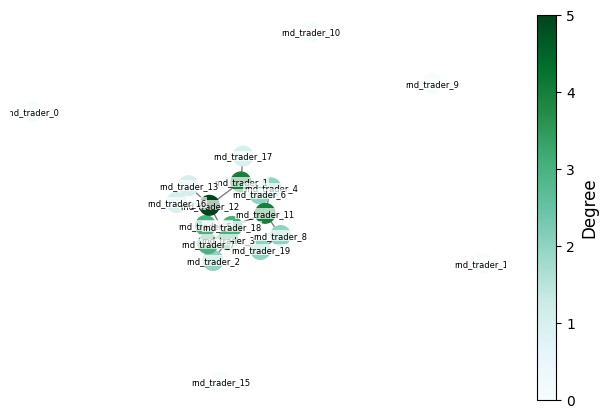

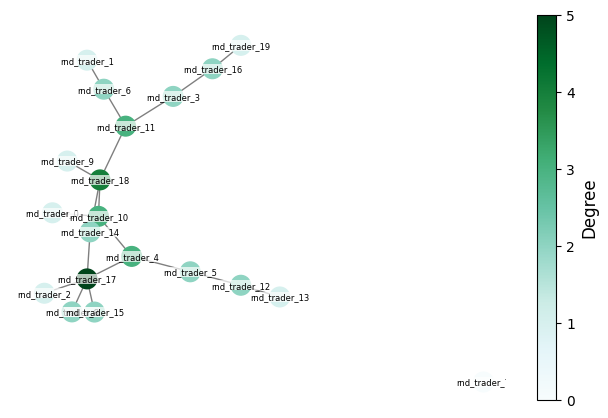

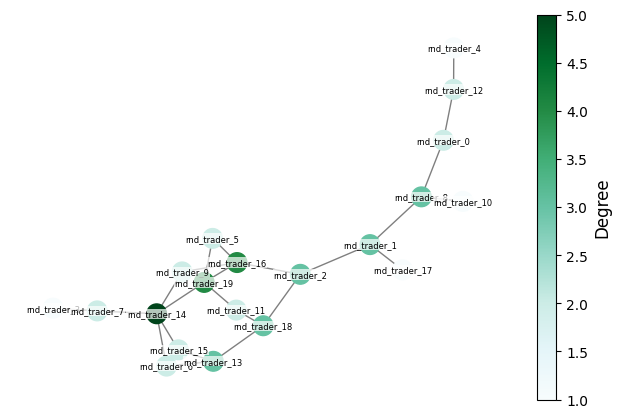

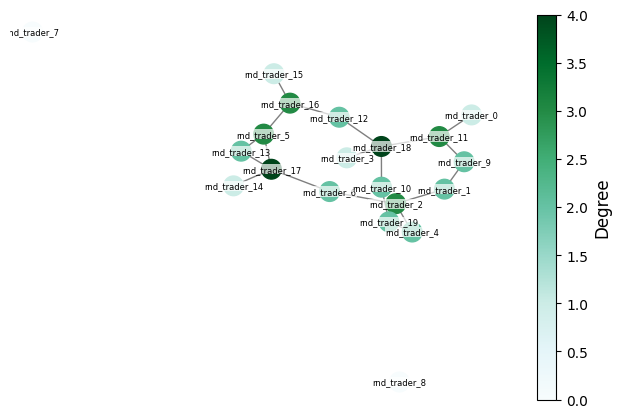

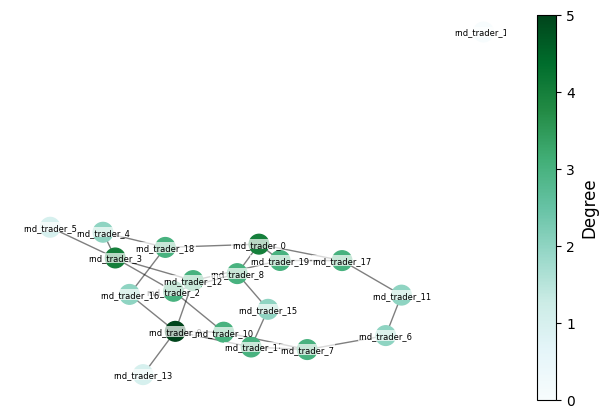

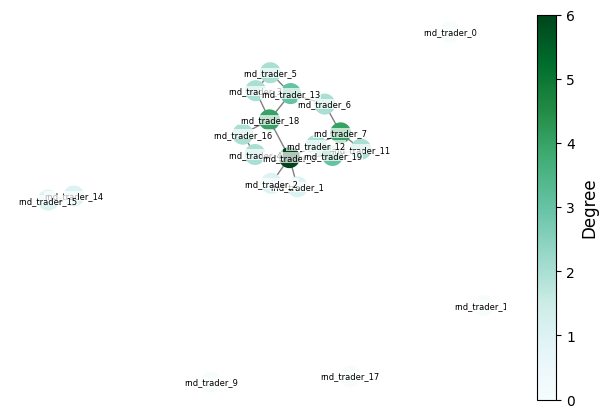

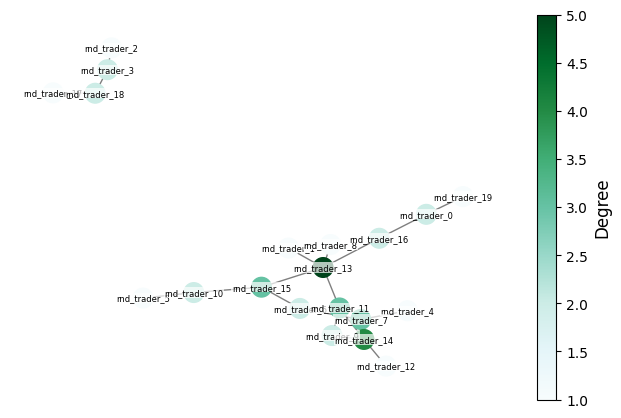

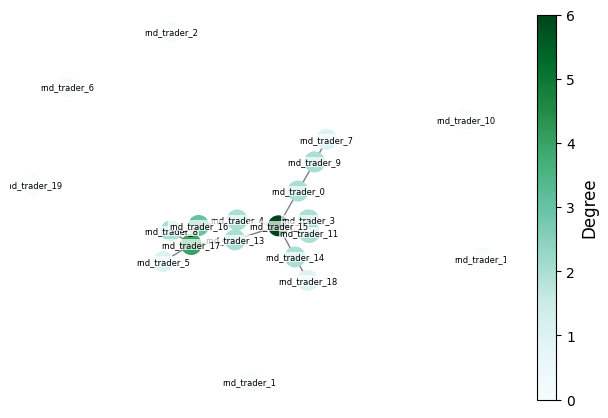

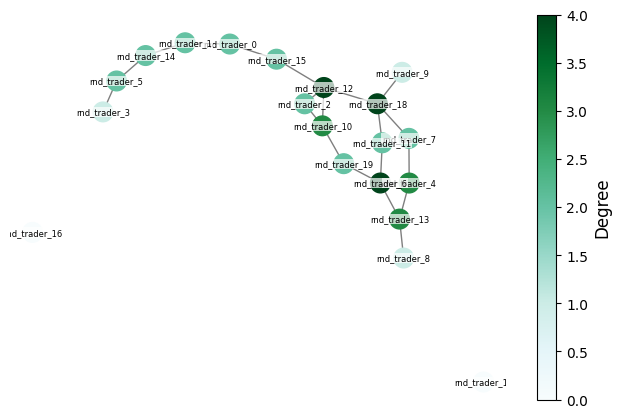

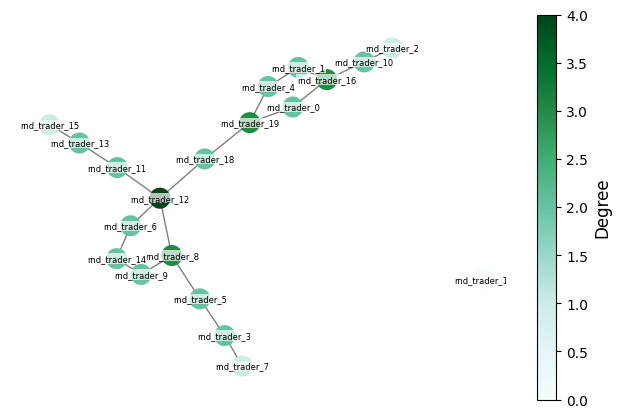

In [21]:
random.seed(42)

for run in range(1):
    model = Market_Model(N_agents = 20, Price = 10)
    
    N_steps = 10
    for step in range(N_steps):
        model.step()

In [22]:
agent_vars = model.datacollector.get_agent_vars_dataframe()
model_vars = model.datacollector.get_model_vars_dataframe()

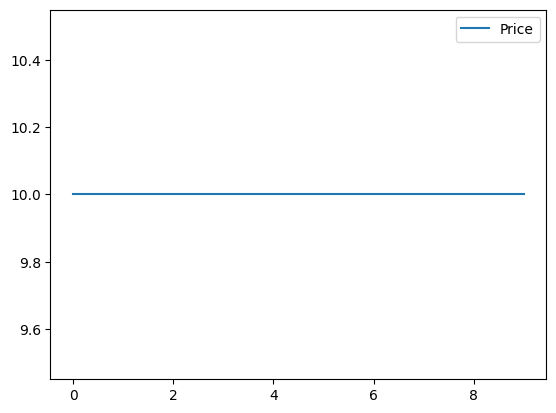

In [23]:
model_vars.plot();

Note that at this point links have no influence on random traders decision!  
We still have to implement that.